In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install sunpy[all]

In [8]:
import os

import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord #### coordenadas para hacer el submap
from astropy.time import Time
from astropy.visualization import ImageNormalize, SqrtStretch

import sunpy.coordinates  # NOQA
import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a

save_dir = "/content/drive/MyDrive/HMI_sdo_Recortes"
os.makedirs(save_dir, exist_ok=True)

In [9]:
####parametros para descarga de datos

"""
# Tiempo de inicio de la observación
start_time = Time('2025-05-09T16:59:08', scale='utc', format='isot')

# Región de interés: 200" x 200" centrada en el disco solar
bottom_left = SkyCoord(-300*u.arcsec, -300*u.arcsec, obstime=start_time,
                        observer="earth", frame="helioprojective")
top_right = SkyCoord(200*u.arcsec, 200*u.arcsec, obstime=start_time,
                      observer="earth", frame="helioprojective")

# Cutout que sigue la rotación solar
cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=True)
"""

'\n# Tiempo de inicio de la observación\nstart_time = Time(\'2025-05-09T16:59:08\', scale=\'utc\', format=\'isot\')\n\n# Región de interés: 200" x 200" centrada en el disco solar\nbottom_left = SkyCoord(-300*u.arcsec, -300*u.arcsec, obstime=start_time,\n                        observer="earth", frame="helioprojective")\ntop_right = SkyCoord(200*u.arcsec, 200*u.arcsec, obstime=start_time,\n                      observer="earth", frame="helioprojective")\n\n# Cutout que sigue la rotación solar\ncutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=True)\n'

In [10]:
###descarga de datos

"""
jsoc_email = "oscarandrescalvo@gmail.com"
time_range = a.Time('2025-05-09T16:59:08', '2025-05-09T21:59:08')


query = Fido.search(
    time_range,
    a.jsoc.Series('hmi.Ic_45s'),
    a.Sample(45*u.s),  # una imagen cada 5 minutos (ajústalo si quieres)
    a.jsoc.Segment('continuum'),  # segmento correcto para intensidad
    a.jsoc.Notify(jsoc_email),
    cutout
)

# Descargar los archivos recortados
#files = Fido.fetch(query)
files = Fido.fetch(query, path=save_dir)
"""


'\njsoc_email = "oscarandrescalvo@gmail.com"\ntime_range = a.Time(\'2025-05-09T16:59:08\', \'2025-05-09T21:59:08\')\n\n\nquery = Fido.search(\n    time_range,\n    a.jsoc.Series(\'hmi.Ic_45s\'),\n    a.Sample(45*u.s),  # una imagen cada 5 minutos (ajústalo si quieres)\n    a.jsoc.Segment(\'continuum\'),  # segmento correcto para intensidad\n    a.jsoc.Notify(jsoc_email),\n    cutout\n)\n\n# Descargar los archivos recortados\n#files = Fido.fetch(query)\nfiles = Fido.fetch(query, path=save_dir)\n'

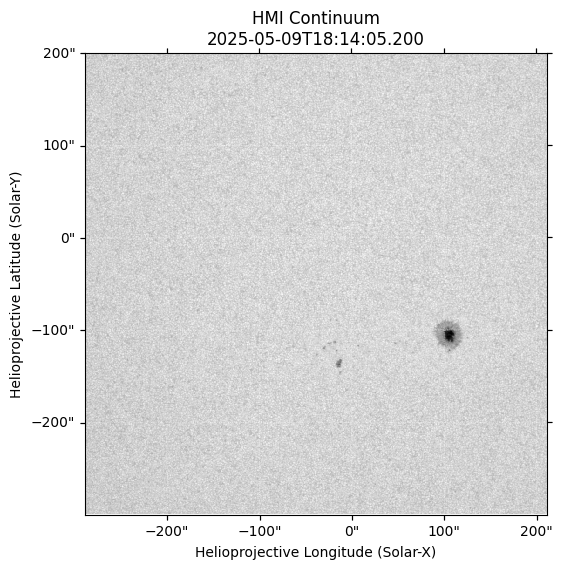

In [11]:
import sunpy.map
import matplotlib.pyplot as plt

import glob
import os

# Ruta a carpeta con los .fits descargados
carpeta_fits = "/content/drive/MyDrive/HMI_sdo_Recortes"

# Listar todos los archivos .fits en la carpeta
files = sorted(glob.glob(os.path.join(carpeta_fits, "*.fits")))

# Seleccionar el primer archivo
m = sunpy.map.Map(files[100])  # o files[n] para cualquier otro

# Graficar con SunPy
plt.figure(figsize=(6,6))
m.plot(cmap='gray', norm=m.plot_settings['norm'])  # escala y contraste correctos
#plt.colorbar()
plt.title(f"HMI Continuum\n{m.date.isot}")
plt.show()

In [12]:
from sunpy.map import Map, MapSequence

maps = Map(sorted(files))  # ordenar por tiempo todos los frames
sequence = MapSequence(maps)


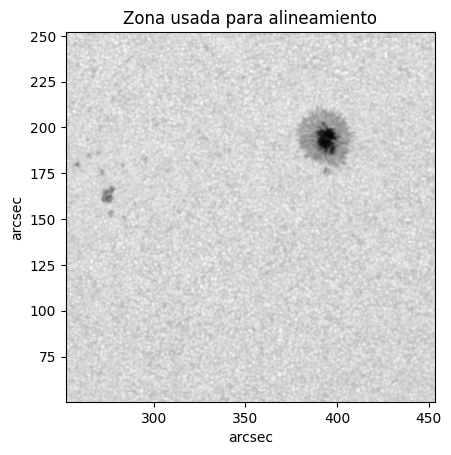

In [13]:

import matplotlib.pyplot as plt
from sunpy.map import Map  # mostrando grafica de la zona de alineamientoS

# Recorte
lim_x = (500, 900)
lim_y = (100, 500)

# Factor de conversión
pixel_scale = 0.504  # arcsec/pixel

# Cargar imagen y recorte
img = Map(files[0]).data
recorte = img[lim_y[0]:lim_y[1], lim_x[0]:lim_x[1]]

# Crear figura
fig, ax = plt.subplots()
im = ax.imshow(recorte, cmap='gray', origin='lower',
               extent=[lim_x[0]*pixel_scale, lim_x[1]*pixel_scale,
                       lim_y[0]*pixel_scale, lim_y[1]*pixel_scale])

ax.set_title("Zona usada para alineamiento")
ax.set_xlabel("arcsec")
ax.set_ylabel("arcsec")
plt.show()

In [14]:
save_dir = "/content/drive/MyDrive/HMI_sdo_alineado"
os.makedirs(save_dir, exist_ok=True)
carpeta="/content/drive/MyDrive/HMI_sdo_alineado"
#!pip install image_registration

In [10]:
"""
import numpy as np
from image_registration import chi2_shift
from scipy.ndimage import shift
from astropy.io import fits
# --- Cargar todas las imágenes como arrays grandes (ej. 1000x1000)
cubo = np.array([Map(f).data for f in files])
shape = cubo.shape

# --- Inicializar cubo alineado y lista de desplazamientos
cubo_alineado = np.empty_like(cubo)
dx_list = [0.0]
dy_list = [0.0]

# --- Primer frame no se alinea, se copia directo
cubo_alineado[0] = cubo[0]

# --- Usar el primer frame como referencia, pero solo en el recorte definido
ref = cubo[0, lim_y[0]:lim_y[1], lim_x[0]:lim_x[1]]

for i in range(1, shape[0]):
    mov = cubo[i, lim_y[0]:lim_y[1], lim_x[0]:lim_x[1]]

    # Calcular shift relativo al primer frame
    dx, dy, _, _ = chi2_shift(ref, mov)

    # Aplicar shift a toda la imagen, no solo al recorte
    cubo_alineado[i] = shift(cubo[i], shift=(-dy, -dx))  # (y, x)

    # Guardar desplazamientos
    dx_list.append(dx)
    dy_list.append(dy)

    print(f"Frame {i}: dx = {dx:.2f}, dy = {dy:.2f}")

# --- Guardar el cubo alineado como .fits
ruta_salida = os.path.join(carpeta, "cubo_HMI_alineado_completo.fits")
margen=100
fits.writeto(ruta_salida, cubo_alineado[:, margen:-margen, margen:-margen], overwrite=True)

# --- Guardar shifts como .txt
np.savetxt(os.path.join(carpeta, "shifts_dx_dy.txt"),
           np.column_stack([dx_list, dy_list]),
           header="dx (pix)    dy (pix)")
"""

'\nimport numpy as np\nfrom image_registration import chi2_shift\nfrom scipy.ndimage import shift\nfrom astropy.io import fits\n# --- Cargar todas las imágenes como arrays grandes (ej. 1000x1000)\ncubo = np.array([Map(f).data for f in files])\nshape = cubo.shape\n\n# --- Inicializar cubo alineado y lista de desplazamientos\ncubo_alineado = np.empty_like(cubo)\ndx_list = [0.0]\ndy_list = [0.0]\n\n# --- Primer frame no se alinea, se copia directo\ncubo_alineado[0] = cubo[0]\n\n# --- Usar el primer frame como referencia, pero solo en el recorte definido\nref = cubo[0, lim_y[0]:lim_y[1], lim_x[0]:lim_x[1]]\n\nfor i in range(1, shape[0]):\n    mov = cubo[i, lim_y[0]:lim_y[1], lim_x[0]:lim_x[1]]\n\n    # Calcular shift relativo al primer frame\n    dx, dy, _, _ = chi2_shift(ref, mov)\n\n    # Aplicar shift a toda la imagen, no solo al recorte\n    cubo_alineado[i] = shift(cubo[i], shift=(-dy, -dx))  # (y, x)\n\n    # Guardar desplazamientos\n    dx_list.append(dx)\n    dy_list.append(dy)\n\n

In [15]:
from astropy.io import fits
import matplotlib.pyplot as plt
ruta_cubo = "/content/drive/MyDrive/HMI_sdo_alineado/cubo_HMI_alineado_completo.fits"
cubo = fits.getdata(ruta_cubo)

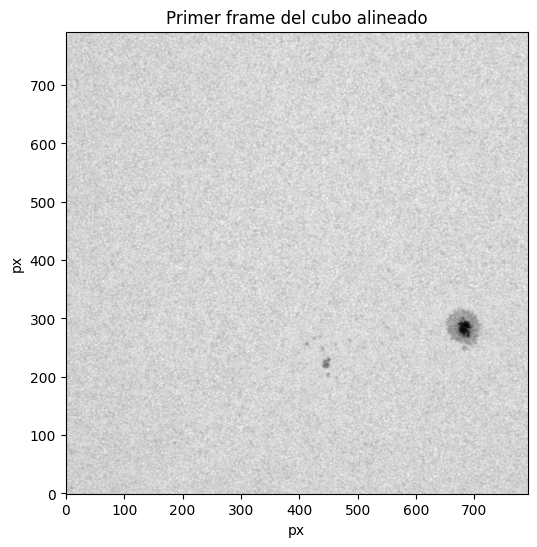

In [16]:
# Cargar cubo alineado
ruta_cubo = "/content/drive/MyDrive/HMI_sdo_alineado/cubo_HMI_alineado_completo.fits"
cubo = fits.getdata(ruta_cubo)

# Elegir un frame para verificar
frame = cubo[0]


# Graficar
plt.figure(figsize=(6,6))
plt.imshow(frame, cmap='gray',origin="lower")
#plt.colorbar()
plt.xlabel("px")#pixeles
plt.ylabel("px")
plt.title("Primer frame del cubo alineado")
plt.show()

In [17]:
#pip install pillow

In [18]:
"""
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cubo[0], cmap='gray', animated=True)
ax.set_title("HMI alineado")
ax.axis('off')

# Función de actualización por frame
def update(frame):
    im.set_array(cubo[frame])
    ax.set_title(f"HMI Alineado - Frame {frame}")
    return [im]

# Crear animación
ani = animation.FuncAnimation(fig, update, frames=cubo.shape[0], interval=100, blit=True)

# Guardar como GIF
ruta_gif = "/content/drive/MyDrive/HMI_sdo_alineado/hmi_matplotlib.gif"
ani.save(ruta_gif, writer='pillow', fps=10)
"""

'\nimport matplotlib.animation as animation\n\nfig, ax = plt.subplots(figsize=(5,5))\nim = ax.imshow(cubo[0], cmap=\'gray\', animated=True)\nax.set_title("HMI alineado")\nax.axis(\'off\')\n\n# Función de actualización por frame\ndef update(frame):\n    im.set_array(cubo[frame])\n    ax.set_title(f"HMI Alineado - Frame {frame}")\n    return [im]\n\n# Crear animación\nani = animation.FuncAnimation(fig, update, frames=cubo.shape[0], interval=100, blit=True)\n\n# Guardar como GIF\nruta_gif = "/content/drive/MyDrive/HMI_sdo_alineado/hmi_matplotlib.gif"\nani.save(ruta_gif, writer=\'pillow\', fps=10)\n'

In [19]:
# Carpeta base donde se guarda todo
import numpy as np
path_base = "/content/drive/MyDrive/HMI_sdo_alineado/cubo_filtrado_p_modes/"

# Subcarpetas requeridas
path_tmp = os.path.join(path_base, "tmp")
path_work = os.path.join(path_tmp, "work")
path_filter = os.path.join(path_tmp, "filter")

# Crear carpetas necesarias
os.makedirs(path_tmp, exist_ok=True)
os.makedirs(path_work, exist_ok=True)
os.makedirs(path_filter, exist_ok=True)


print("Forma del cubo:", cubo.shape)
print("Valores mínimos y máximos:", np.min(cubo), np.max(cubo))

cubo = (cubo - np.min(cubo)) / (np.max(cubo) - np.min(cubo))
print("Valores normalizados:", np.min(cubo), np.max(cubo))



Forma del cubo: (401, 792, 792)
Valores mínimos y máximos: 7877.9663 55231.875
Valores normalizados: 0.0 1.0


In [16]:
"""
import sys
sys.path.append('/content/drive/MyDrive/filtro_p_modes/filtro_p_modes')
from astropy.io import fits
from bigsonic_hmi import bigsonic
import os

# --- Ruta al cubo alineado original ---
ruta_entrada = "/content/drive/MyDrive/HMI_sdo_alineado/cubo_HMI_alineado_completo.fits"
cubo = fits.getdata(ruta_entrada)

# --- Parámetros del filtro ---
first = 0
last = cubo.shape[0] - 1
bxdim = 128
bydim = 128

# --- Carpeta de trabajo en Google Drive ---
path_base = "/content/drive/MyDrive/HMI_sdo_alineado/cubo_filtrado_p_modes/"
os.makedirs(path_base, exist_ok=True)

# Subcarpetas que el filtro espera
path_tmp = os.path.join(path_base, "tmp")
os.makedirs(path_tmp, exist_ok=True)

# --- Ejecutar el filtrado de modos p ---
cubo_filtrado = bigsonic(cubo, first, last, bxdim, bydim, path_tmp)

# --- Guardar el cubo filtrado en la misma carpeta ---
ruta_salida = os.path.join(path_base, "cubo_HMI_filtrado_p.fits")
fits.writeto(ruta_salida, cubo_filtrado, overwrite=True)

"""

'\nimport sys\nsys.path.append(\'/content/drive/MyDrive/filtro_p_modes/filtro_p_modes\')\nfrom astropy.io import fits\nfrom bigsonic_hmi import bigsonic\nimport os\n\n# --- Ruta al cubo alineado original ---\nruta_entrada = "/content/drive/MyDrive/HMI_sdo_alineado/cubo_HMI_alineado_completo.fits"\ncubo = fits.getdata(ruta_entrada)\n\n# --- Parámetros del filtro ---\nfirst = 0\nlast = cubo.shape[0] - 1\nbxdim = 128\nbydim = 128\n\n# --- Carpeta de trabajo en Google Drive ---\npath_base = "/content/drive/MyDrive/HMI_sdo_alineado/cubo_filtrado_p_modes/"\nos.makedirs(path_base, exist_ok=True)\n\n# Subcarpetas que el filtro espera\npath_tmp = os.path.join(path_base, "tmp")\nos.makedirs(path_tmp, exist_ok=True)\n\n# --- Ejecutar el filtrado de modos p ---\ncubo_filtrado = bigsonic(cubo, first, last, bxdim, bydim, path_tmp)\n\n# --- Guardar el cubo filtrado en la misma carpeta ---\nruta_salida = os.path.join(path_base, "cubo_HMI_filtrado_p.fits")\nfits.writeto(ruta_salida, cubo_filtrado, over

In [20]:
ruta_cubo = "/content/drive/MyDrive/HMI_sdo_alineado/cubo_filtrado_p_modes/cubo_HMI_filtrado_p.fits"
cubo_filtrado = fits.getdata(ruta_cubo)

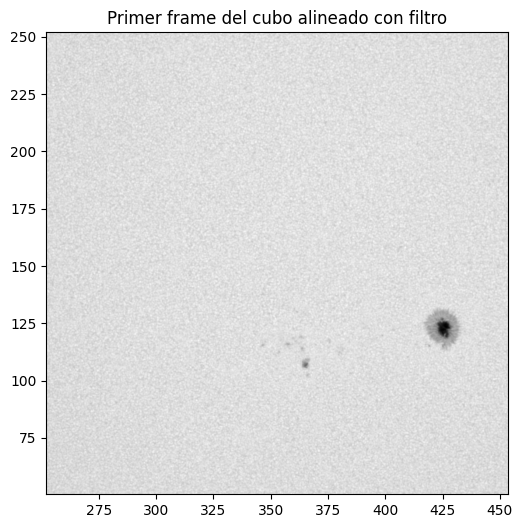

In [21]:
plt.figure(figsize=(6,6))
plt.imshow(cubo_filtrado[399], cmap='gray',origin="lower",extent=[lim_x[0]*pixel_scale, lim_x[1]*pixel_scale,
                       lim_y[0]*pixel_scale, lim_y[1]*pixel_scale])
#plt.colorbar()
plt.title("Primer frame del cubo alineado con filtro")
plt.show()
#

In [ ]:
##### entrenamiento

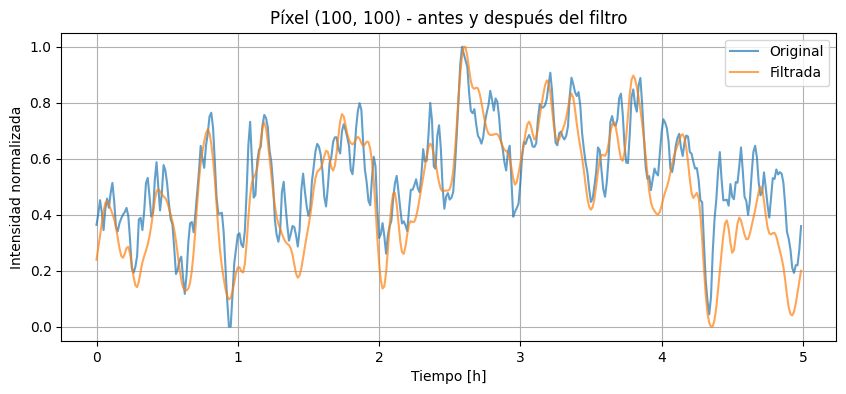

In [22]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Escoge un píxel (x, y)
x, y = 100, 100
ruta_cubo = "/content/drive/MyDrive/HMI_sdo_alineado/cubo_HMI_alineado_completo.fits"
cubo = fits.getdata(ruta_cubo)

# Extrae la serie temporal
serie_original = cubo[:, y, x]
serie_filtrada = cubo_filtrado[:, y, x]

# Asegurar misma longitud
min_len = min(len(serie_original), len(serie_filtrada))
serie_original = serie_original[:min_len]
serie_filtrada = serie_filtrada[:min_len]

# Normalización
def normalizar_minmax(serie):
    return (serie - np.min(serie)) / (np.max(serie) - np.min(serie))

serie_original = normalizar_minmax(serie_original)
serie_filtrada = normalizar_minmax(serie_filtrada)

# Tiempo en segundos
tiempo = np.arange(min_len) * 45/3600  # 45 s por frame

# Gráfica
plt.figure(figsize=(10, 4))
plt.plot(tiempo, serie_original, label="Original", alpha=0.7)
plt.plot(tiempo, serie_filtrada, label="Filtrada", alpha=0.7)
plt.legend()
plt.xlabel("Tiempo [h]")
plt.ylabel("Intensidad normalizada")
plt.title(f"Píxel ({x}, {y}) - antes y después del filtro")
plt.grid(True)
plt.show()

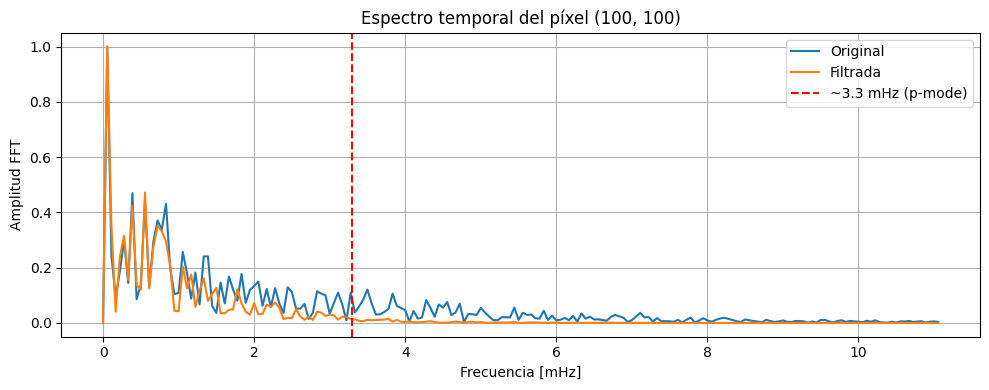

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Paso temporal en segundos (HMI = 45 s)
t_step = 45

# Asegurar misma longitud
min_len = min(len(serie_original), len(serie_filtrada))
serie_original = serie_original[:min_len]
serie_filtrada = serie_filtrada[:min_len]

# Normalización min-max antes de la FFT (opcional pero mejora comparación de formas)
def normalizar_minmax(serie):
    return (serie - np.min(serie)) / (np.max(serie) - np.min(serie))

serie_original = normalizar_minmax(serie_original)
serie_filtrada = normalizar_minmax(serie_filtrada)



# Quitar la media para el análisis de frecuencias
fft_orig = np.abs(fft(serie_original - np.mean(serie_original)))
fft_filt = np.abs(fft(serie_filtrada - np.mean(serie_filtrada)))


fft_orig /= np.max(fft_orig)
fft_filt /= np.max(fft_filt)
# Frecuencias [Hz] y conversión a miliHertz (mHz)
N = min_len
frequencies = fftfreq(N, d=t_step)
frequencies_mHz = frequencies * 1000

# Mostrar solo la mitad positiva del espectro
half = N // 2

plt.figure(figsize=(10, 4))
plt.plot(frequencies_mHz[:half], fft_orig[:half], label='Original')
plt.plot(frequencies_mHz[:half], fft_filt[:half], label='Filtrada')
plt.axvline(3.3, color='red', linestyle='--', label='~3.3 mHz (p-mode)')
plt.xlabel("Frecuencia [mHz]")
plt.ylabel("Amplitud FFT")
plt.title(f"Espectro temporal del píxel ({x}, {y})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.fft import fft, fftfreq

# Cargar tus cubos .fits
from astropy.io import fits


# ---- Parámetros ----
signal_len = 150        # longitud de la señal temporal
num_samples = 10000     # número de muestras de entrenamiento
t_step = 45             # segundos entre frames

T, H, W = cubo.shape
cubo = (cubo - np.min(cubo)) / (np.max(cubo) - np.min(cubo))
cubo_filtrado = (cubo_filtrado - np.min(cubo_filtrado)) / (np.max(cubo_filtrado) - np.min(cubo_filtrado))

# Extraer señales
X_signals = []
Y_signals = []

for _ in range(num_samples):
    y = np.random.randint(0, H)
    x = np.random.randint(0, W)
    t0 = np.random.randint(0, T - signal_len)

    sig_in = cubo[t0:t0+signal_len, y, x]
    sig_out = cubo_filtrado[t0:t0+signal_len, y, x]

    X_signals.append(sig_in)
    Y_signals.append(sig_out)

X = np.array(X_signals)
Y = np.array(Y_signals)

# ---- Modelo ----
model = models.Sequential([
    layers.Input(shape=(signal_len,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(signal_len)  # salida: señal transformada
])

model.compile(optimizer="adam", loss="mse")
model.summary()

# ---- Entrenamiento ----
history = model.fit(X, Y, validation_split=0.2, epochs=250, batch_size=32)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 150)            │         9,750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,574 (92.09 KB)

 Trainable params: 23,574 (92.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1689 - val_loss: 0.0011
Epoch 2/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 - val_loss: 9.9827e-04
Epoch 4/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9369e-04 - val_loss: 9.5686e-04
Epoch 5/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5267e-04 - val_loss: 9.2726e-04
Epoch 6/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1715e-04 - val_loss: 8.9807e-04
Epoch 7/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9852e-04 - val_loss: 8.6212e-04
Epoch 8/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6572e-04 - val_loss: 8.3195e-04
Epoch 9/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3460e-04 - val_loss: 7.9427e-04
Epoch 10/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9252e-04 - val_loss: 7.7175e-04
Epoch 11/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.6858e

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from astropy.io import fits

# === 1. Parámetros ===
signal_len = 150        # longitud temporal
num_samples = 10000     # señales aleatorias
t_step = 45             # segundos entre imágenes

# === 2. Normalizar ===
cubo = (cubo - np.min(cubo)) / (np.max(cubo) - np.min(cubo))
cubo_filtrado = (cubo_filtrado - np.min(cubo_filtrado)) / (np.max(cubo_filtrado) - np.min(cubo_filtrado))

T, H, W = cubo.shape

# === 3. Extraer señales aleatorias ===
X_signals, Y_signals = [], []

for _ in range(num_samples):
    y = np.random.randint(0, H)
    x = np.random.randint(0, W)
    t0 = np.random.randint(0, T - signal_len)

    sig_in = cubo[t0:t0+signal_len, y, x]
    sig_out = cubo_filtrado[t0:t0+signal_len, y, x]

    X_signals.append(sig_in)
    Y_signals.append(sig_out)

X = np.array(X_signals)  # (samples, 150)
Y = np.array(Y_signals)

# === 4. Modelo simple denso ===
model = models.Sequential([
    layers.Input(shape=(signal_len,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(signal_len)  # salida: misma longitud temporal
])

model.compile(optimizer="adam", loss="mse")
model.summary()

# === 5. Entrenamiento ===
history = model.fit(X, Y, validation_split=0.2, epochs=200, batch_size=32)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 150)            │         9,750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,574 (92.09 KB)

 Trainable params: 23,574 (92.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1610 - val_loss: 0.0010
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 - val_loss: 9.7284e-04
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4684e-04 - val_loss: 9.1996e-04
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.1395e-04 - val_loss: 9.0345e-04
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.8517e-04 - val_loss: 8.7154e-04
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.5513e-04 - val_loss: 8.4925e-04
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3917e-04 - val_loss: 8.2230e-04
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0356e-04 - val_loss: 8.0041e-04
Epoch 9/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9558e-04 - val_loss: 7.8202e-04
Epoch 10/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7596e-04 - val_loss: 7.6904e-04
Epoch 11/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

In [34]:
# Extraer el parche original
parche_original = cubo[:150, :250, :250]  # (T, H, W) = (150, 200, 200)

# Reorganizar a (N, T), donde N = H * W
T, H, W = parche_original.shape
X = parche_original.transpose(1, 2, 0).reshape(-1, T)  # (200*200, 150)

# Normalizar cada fila
X_mean = X.mean(axis=1, keepdims=True)
X_std = X.std(axis=1, keepdims=True)
X_norm = (X - X_mean) / X_std

# Predecir con el modelo
Y_pred = model.predict(X_norm, batch_size=512, verbose=1)  # (200*200, 150)

# Reconstruir a (T, H, W)
parche_predicho = Y_pred.reshape(H, W, T).transpose(2, 0, 1)  # (150, 200, 200)



123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/tmp/ipython-input-35-1725916055.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])
/tmp/ipython-input-35-1725916055.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels([f"{y * arcsec_per_px:.1f}" for y in yticks])
/tmp/ipython-input-35-1725916055.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])
/tmp/ipython-input-35-1725916055.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])


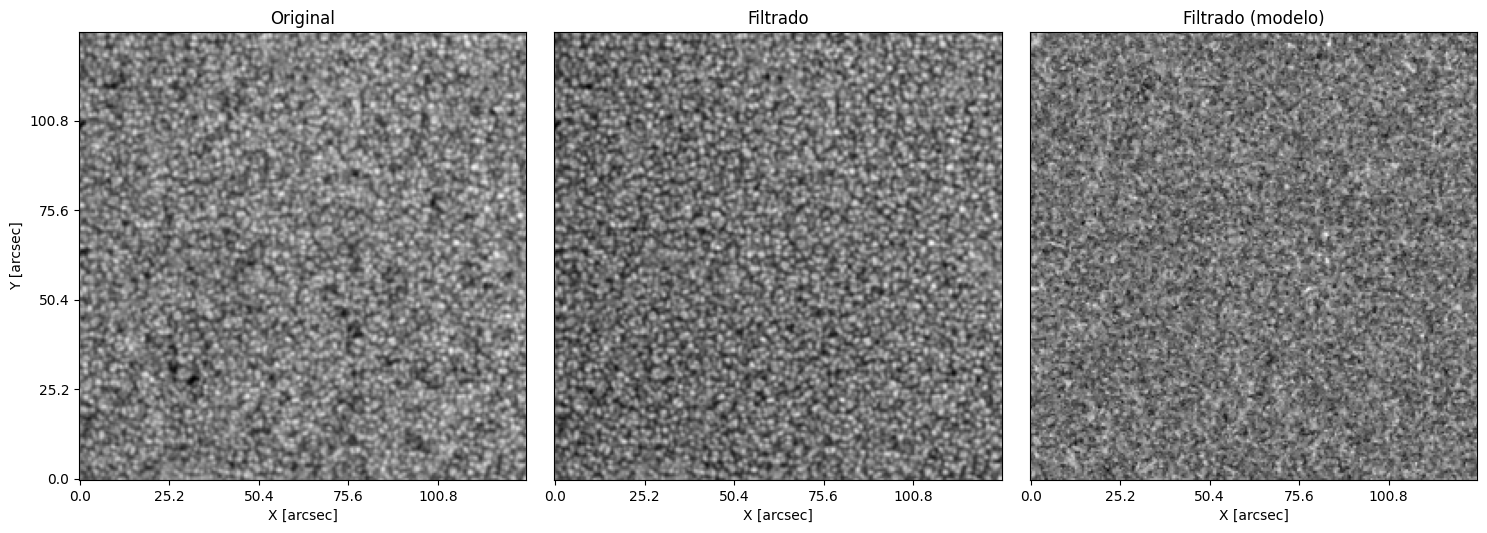

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Supuestos previos
arcsec_per_px = 0.504
t = 40

mean = np.mean(parche_original, axis=0)
std  = np.std(parche_original, axis=0) + 1e-8
parche_original_norm = (parche_original - mean) / std

img_original = parche_original[t]
img_filtrado_re = parche_predicho[t]
img_filtrado = cubo_filtrado[t, :250, :250]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Imagen original con ejes en arcosegundos
axs[0].imshow(img_original, cmap='gray', origin='lower')
axs[0].set_title("Original")

# Ticks en píxeles
xticks = axs[0].get_xticks()
yticks = axs[0].get_yticks()

# Convertir a arcosegundos
axs[0].set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])
axs[0].set_yticklabels([f"{y * arcsec_per_px:.1f}" for y in yticks])

axs[0].set_xlabel("X [arcsec]")
axs[0].set_ylabel("Y [arcsec]")

# Imagen filtrada con solo eje X en arcosegundos
axs[1].imshow(img_filtrado, cmap='gray', origin='lower')
axs[1].set_title("Filtrado")
xticks = axs[1].get_xticks()
axs[1].set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])
axs[1].set_xlabel("X [arcsec]")
axs[1].tick_params(left=False, labelleft=False)

# Imagen filtrada por modelo con solo eje X en arcosegundos
axs[2].imshow(img_filtrado_re, cmap='gray', origin='lower')
axs[2].set_title("Filtrado (modelo)")
xticks = axs[2].get_xticks()
axs[2].set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])
axs[2].set_xlabel("X [arcsec]")
axs[2].tick_params(left=False, labelleft=False)

plt.tight_layout()
plt.show()

/tmp/ipython-input-37-496588636.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])
/tmp/ipython-input-37-496588636.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y * arcsec_per_px:.1f}" for y in yticks])
/tmp/ipython-input-37-496588636.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])
/tmp/ipython-input-37-496588636.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])


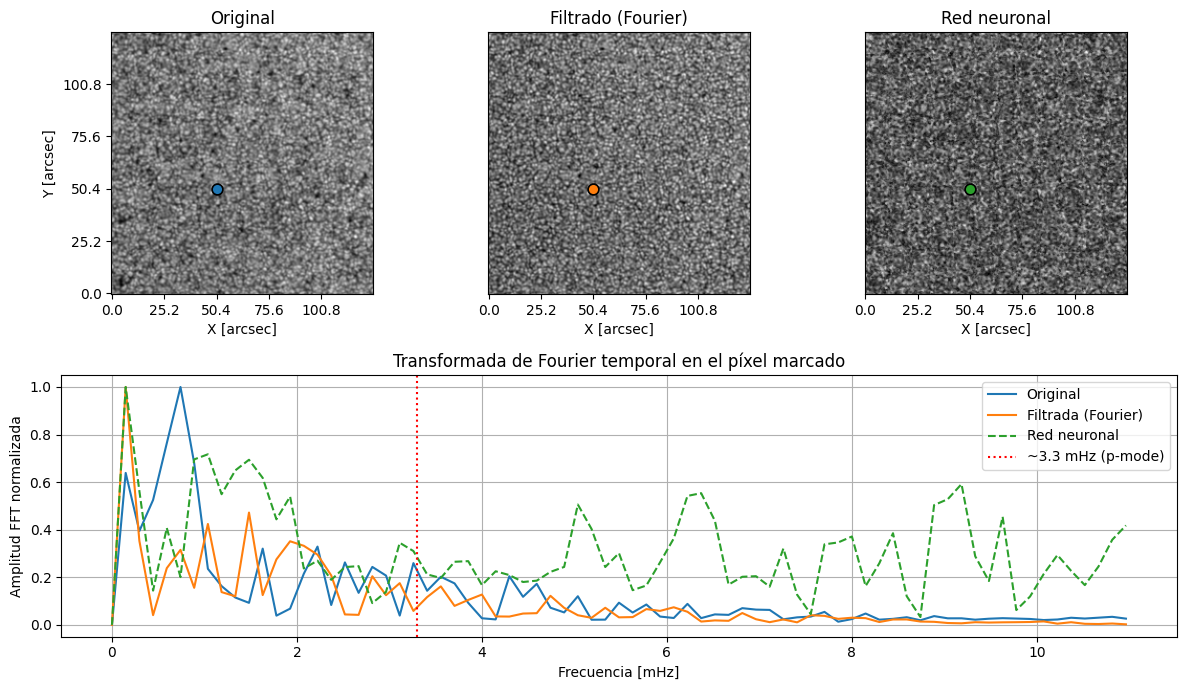

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.fft import fft, fftfreq

# === Parámetros ===
arcsec_per_px = 0.504
t_step = 45
t = 2
x_pix, y_pix = 100, 100   # posición del píxel marcado

# === Imagen en ese instante ===
mean = np.mean(parche_original, axis=0)
std = np.std(parche_original, axis=0) + 1e-8
parche_original_norm = (parche_original - mean) / std

img_original = parche_original[t]
img_filtrado = parche_predicho[t]
img_diferencia = cubo_filtrado[t, :250, :250]

def normalizar(img):
    mean = np.mean(img)
    std = np.std(img) + 1e-8
    return (img - mean) / std

img_original = normalizar(img_original)
img_filtrado = normalizar(img_filtrado)
img_diferencia = normalizar(img_diferencia)

# === FFT temporal ===
def normalizar_minmax(sig):
    return (sig - np.min(sig)) / (np.max(sig) - np.min(sig) + 1e-8)

def clean_fft(sig):
    return np.abs(fft(sig - np.mean(sig)))

signal_original = parche_original[:, y_pix, x_pix]
signal_filtrada = cubo_filtrado[:, y_pix, x_pix]
signal_predicha = parche_predicho[:, y_pix, x_pix]

# Normalizar las tres señales antes de la FFT
signal_original = normalizar_minmax(signal_original)
signal_filtrada = normalizar_minmax(signal_filtrada)
signal_predicha = normalizar_minmax(signal_predicha)

# FFT (tras quitar media)
fft_orig = clean_fft(signal_original)
fft_filt = clean_fft(signal_filtrada)
fft_pred = clean_fft(signal_predicha)

# Normalizar espectros para comparar amplitudes relativas
fft_orig /= np.max(fft_orig)
fft_filt /= np.max(fft_filt)
fft_pred /= np.max(fft_pred)

freqs = fftfreq(len(signal_original), d=t_step) * 1000  # mHz
half = len(freqs) // 2

# === Grilla general ===
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(2, 3, height_ratios=[1, 1], figure=fig)

titles = ["Original", "Filtrado (Fourier)", "Red neuronal"]
imagenes = [img_original, img_diferencia, img_filtrado]
colors = ["tab:blue", "tab:orange", "tab:green"]

# === Paneles de imagen ===
for i in range(3):
    ax = fig.add_subplot(gs[0, i])
    im = ax.imshow(imagenes[i], cmap='gray', origin='lower')

    # Ticks en arcosegundos
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    ax.set_xticklabels([f"{x * arcsec_per_px:.1f}" for x in xticks])
    if i == 0:
        ax.set_yticklabels([f"{y * arcsec_per_px:.1f}" for y in yticks])
        ax.set_ylabel("Y [arcsec]")
    else:
        ax.set_yticks([])

    ax.set_xlabel("X [arcsec]")
    ax.set_title(titles[i])

    # Punto marcado
    ax.scatter(x_pix, y_pix, color=colors[i], s=60, edgecolor='black', linewidth=1.2)

# === Panel FFT ===
ax_fft = fig.add_subplot(gs[1, :])
ax_fft.plot(freqs[:half], fft_orig[:half], label="Original", color=colors[0])
ax_fft.plot(freqs[:half], fft_filt[:half], label="Filtrada (Fourier)", color=colors[1])
ax_fft.plot(freqs[:half], fft_pred[:half], label="Red neuronal", color=colors[2], linestyle='--')

ax_fft.axvline(3.3, color='red', linestyle=':', label='~3.3 mHz (p-mode)')

ax_fft.set_xlabel("Frecuencia [mHz]")
ax_fft.set_ylabel("Amplitud FFT normalizada")
ax_fft.set_title("Transformada de Fourier temporal en el píxel marcado")
ax_fft.grid(True)
ax_fft.legend()

plt.tight_layout()
plt.show()

In [1]:

"""
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Crear figura y ejes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Mostrar primer frame
im0 = axs[0].imshow(parche_original[0], cmap='gray', animated=True)
axs[0].set_title("Original")
axs[0].axis('off')

im1 = axs[1].imshow(cubo_filtrado[0, :300, :300], cmap='gray', animated=True)
axs[1].set_title("Filtrado (Fourier)")
axs[1].axis('off')

im2 = axs[2].imshow(parche_predicho[0], cmap='gray', animated=True)
axs[2].set_title("Filtrado (modelo)")
axs[2].axis('off')

# Función de actualización por frame
def update(frame):
    im0.set_array(parche_original[frame])
    im1.set_array(cubo_filtrado[frame, :300, :300])
    im2.set_array(parche_predicho[frame])
    fig.suptitle(f"Frame {frame}", fontsize=16)
    return [im0, im1, im2]

# Crear animación
ani = animation.FuncAnimation(fig, update, frames=150, interval=100, blit=True)

# Guardar como GIF
ruta_gif = "/content/drive/MyDrive/HMI_sdo_alineado/filtrado_vs_modelo.gif"
ani.save(ruta_gif, writer='pillow', fps=10)

"""

'\nimport matplotlib.pyplot as plt\nimport matplotlib.animation as animation\n\n# Crear figura y ejes\nfig, axs = plt.subplots(1, 3, figsize=(15, 5))\n\n# Mostrar primer frame\nim0 = axs[0].imshow(parche_original[0], cmap=\'gray\', animated=True)\naxs[0].set_title("Original")\naxs[0].axis(\'off\')\n\nim1 = axs[1].imshow(cubo_filtrado[0, :300, :300], cmap=\'gray\', animated=True)\naxs[1].set_title("Filtrado (Fourier)")\naxs[1].axis(\'off\')\n\nim2 = axs[2].imshow(parche_predicho[0], cmap=\'gray\', animated=True)\naxs[2].set_title("Filtrado (modelo)")\naxs[2].axis(\'off\')\n\n# Función de actualización por frame\ndef update(frame):\n    im0.set_array(parche_original[frame])\n    im1.set_array(cubo_filtrado[frame, :300, :300])\n    im2.set_array(parche_predicho[frame])\n    fig.suptitle(f"Frame {frame}", fontsize=16)\n    return [im0, im1, im2]\n\n# Crear animación\nani = animation.FuncAnimation(fig, update, frames=150, interval=100, blit=True)\n\n# Guardar como GIF\nruta_gif = "/content/

# **Los demas son tambien intentos no exitosos**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
signal_len = 150
t_show = 75  # frame a mostrar
y0, x0 = 20, 20  # esquina del parche
patch_y, patch_x = 200, 200  # tamaño del parche

# 1. Recorta cubo temporalmente
cubo_150 = cubo[:signal_len]
cubo_filtrado_150 = cubo_filtrado[:signal_len]

# 2. Normalización min-max
def normalizar_minmax(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

cubo_150 = normalizar_minmax(cubo_150)
cubo_filtrado_150 = normalizar_minmax(cubo_filtrado_150)

# 3. Extrae señales temporales de cada píxel del parche
señales_entrada = []
for j in range(patch_y):
    for i in range(patch_x):
        señal = cubo_150[:, y0 + j, x0 + i]
        señales_entrada.append(señal)

señales_entrada = np.array(señales_entrada)  # shape (N, 150)

# 4. Predicción con la red neuronal
señales_predichas = model.predict(señales_entrada, batch_size=32, verbose=1)

# 5. Reconstruye el cubo predicho
cubo_predicho = np.zeros((signal_len, patch_y, patch_x))
for idx, (j, i) in enumerate([(j, i) for j in range(patch_y) for i in range(patch_x)]):
    cubo_predicho[:, j, i] = señales_predichas[idx]



plt.plot(cubo_150[:, y0+50, x0+50], label="Original")
plt.plot(cubo_filtrado_150[:, y0+50, x0+50], label="Fourier")
plt.plot(cubo_predicho[:, 50, 50], label="Red")
plt.legend()
plt.title("Señal temporal en un píxel")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === 1. Recortar subimagen de 200x200 centrada (opcional, si cubo es más grande) ===
T, H, W = cubo.shape

# Coordenadas para recorte centrado
y0 = (H - 200) // 2
x0 = (W - 200) // 2
subcubo = cubo[:, y0:y0+200, x0:x0+200]  # (65, 200, 200)

# === 2. Extraer parche pequeño de 64x64 dentro del subcubo ===
# Por ejemplo, parche centrado dentro de 200x200
yy = (200 - 64) // 2
xx = (200 - 64) // 2
parche = subcubo[:, yy:yy+64, xx:xx+64]  # (65, 64, 64)

# === 3. Preparar para red (agregar dimensión batch) ===
parche_input = parche[np.newaxis, ...]  # (1, 65, 64, 64)

# === 4. Aplicar modelo ===
salida_filtrada = model.predict(parche_input)[0]  # (65, 64, 64)

# === 5. Visualizar frame central ===
t = 32
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(parche[t], cmap='gray')
axs[0].set_title("Original t=32")
axs[1].imshow(salida_filtrada[t], cmap='gray')
axs[1].set_title("Filtrado t=32")
plt.tight_layout()
plt.show()

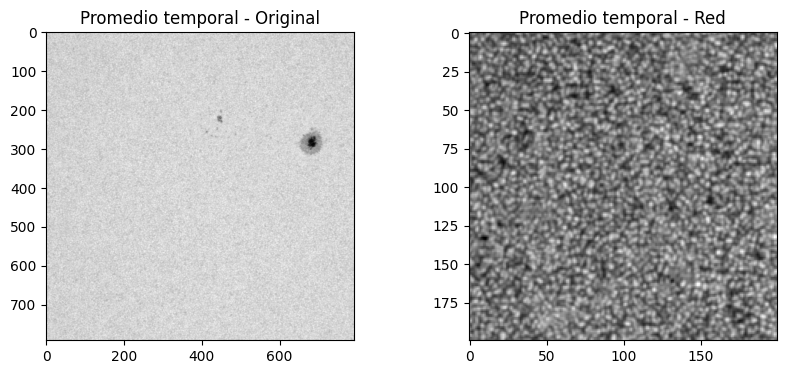

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cubo_150[5], cmap='gray')
plt.title("Promedio temporal - Original")

plt.subplot(1, 2, 2)
plt.imshow(cubo_predicho[100], cmap='gray')
plt.title("Promedio temporal - Red")
plt.show()

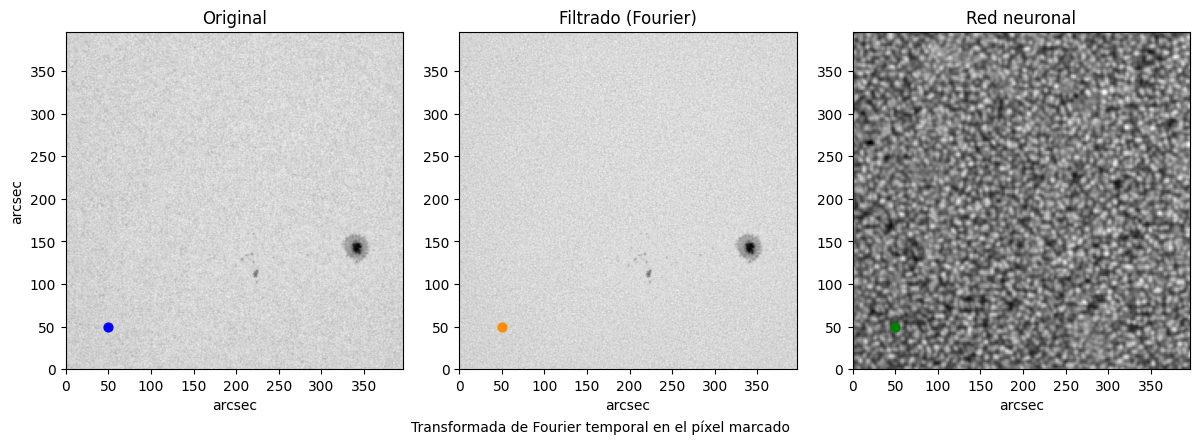

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Variables ===
# Estos deben estar definidos previamente:
# cubo: np.ndarray de forma (T, H, W)
# cubo_filtrada: np.ndarray de forma (T, H, W)
# predicho: np.ndarray de forma (T, H, W)
# pixel: tupla (y, x) indicando el píxel de referencia

# === Frame central ===
frame = 100
y, x = 100,100

# === Conversión de escala ===
arcsec_per_pixel = 0.5  # ajusta según corresponda
extent = [0, cubo.shape[2] * arcsec_per_pixel,
          0, cubo.shape[1] * arcsec_per_pixel]

# === Gráfica ===
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# 1. Original
axs[0].imshow(cubo[frame], cmap='gray', origin='lower', extent=extent)
axs[0].scatter(x * arcsec_per_pixel, y * arcsec_per_pixel, s=40, color='blue')
axs[0].set_title("Original")
axs[0].set_xlabel("arcsec")
axs[0].set_ylabel("arcsec")

# 2. Filtrado (Fourier)
axs[1].imshow(cubo_filtrado[frame], cmap='gray', origin='lower', extent=extent)
axs[1].scatter(x * arcsec_per_pixel, y * arcsec_per_pixel, s=40, color='darkorange')
axs[1].set_title("Filtrado (Fourier)")
axs[1].set_xlabel("arcsec")
axs[1].set_ylabel("")

# 3. Red neuronal
axs[2].imshow(cubo_predicho[frame], cmap='gray', origin='lower', extent=extent)
axs[2].scatter(x * arcsec_per_pixel, y * arcsec_per_pixel, s=40, color='green')
axs[2].set_title("Red neuronal")
axs[2].set_xlabel("arcsec")
axs[2].set_ylabel("")

# Texto inferior
plt.figtext(0.5, -0.05, "Transformada de Fourier temporal en el píxel marcado", ha='center', fontsize=10)

plt.show()

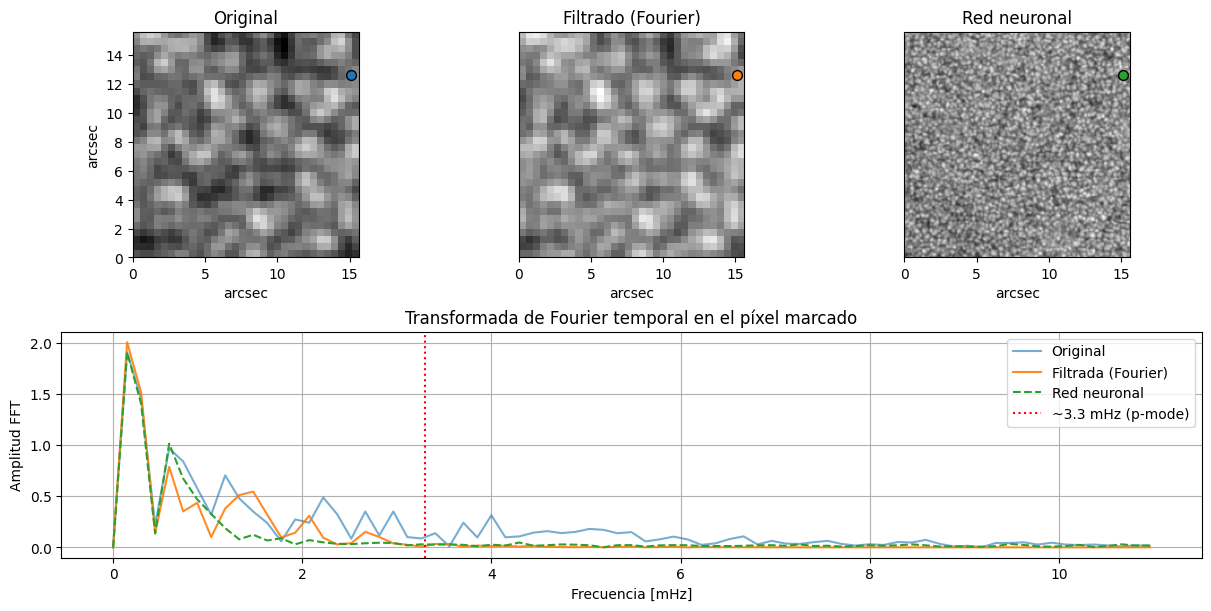

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.fft import fft, fftfreq

# === Parámetros ===
pixel_scale = 0.504  # arcsec/píxel
t_step = 45
t_show = 70
patch_x, patch_y = 32, 32
x_vals = np.arange(patch_x) * pixel_scale
y_vals = np.arange(patch_y) * pixel_scale

# Píxel seleccionado (relativo al parche)
x_pix_rel = 30
y_pix_rel = 25

# === Señales temporales ===
signal_original = cubo_150[:, y0 + y_pix_rel, x0 + x_pix_rel]
signal_filtrada = cubo_filtrado_150[:, y0 + y_pix_rel, x0 + x_pix_rel]
signal_predicha = cubo_predicho[:, y_pix_rel, x_pix_rel]

# === FFT ===
def clean_fft(sig):
    return np.abs(fft(sig - np.mean(sig)))

fft_orig = clean_fft(signal_original)
fft_filt = clean_fft(signal_filtrada)
fft_pred = clean_fft(signal_predicha)

freqs = fftfreq(len(signal_original), d=t_step) * 1000  # mHz
half = len(freqs) // 2

# === Imágenes ===
titles = ["Original", "Filtrado (Fourier)", "Red neuronal"]
cubos = [
    cubo_150[t_show, y0:y0+patch_y, x0:x0+patch_x],
    cubo_filtrado_150[t_show, y0:y0+patch_y, x0:x0+patch_x],
    cubo_predicho[t_show]
]
colors = ["tab:blue", "tab:orange", "tab:green"]

# === Escala común de color ===
vmin = min(np.min(c) for c in cubos)
vmax = max(np.max(c) for c in cubos)

# === Grilla ===
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = GridSpec(2, 3, height_ratios=[1, 1], figure=fig)

# --- Paneles de imagen ---
for i in range(3):
    ax = fig.add_subplot(gs[0, i])
    im = ax.imshow(cubos[i],
                   cmap='gray',
                   extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]],
                   origin='lower',
                   vmin=vmin, vmax=vmax)
    ax.scatter(x_vals[x_pix_rel], y_vals[y_pix_rel], color=colors[i], s=50, edgecolor="black")
    ax.set_title(titles[i])
    ax.set_xlabel("arcsec")
    if i == 0:
        ax.set_ylabel("arcsec")
    else:
        ax.set_yticks([])

# --- Panel de espectro FFT ---
ax_fft = fig.add_subplot(gs[1, :])
ax_fft.plot(freqs[:half], fft_orig[:half], label="Original", color=colors[0], alpha=0.6)
ax_fft.plot(freqs[:half], fft_filt[:half], label="Filtrada (Fourier)", color=colors[1], alpha=0.9)
ax_fft.plot(freqs[:half], fft_pred[:half], label="Red neuronal", color=colors[2], linestyle="--")
ax_fft.axvline(3.3, color='red', linestyle=':', label='~3.3 mHz (p-mode)')

ax_fft.set_title("Transformada de Fourier temporal en el píxel marcado")
ax_fft.set_xlabel("Frecuencia [mHz]")
ax_fft.set_ylabel("Amplitud FFT")
ax_fft.grid(True)
ax_fft.legend()

plt.show()

In [ ]:
t_show = 100

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cubo[t_show, y0:y0+patch_y, x0:x0+patch_x], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Filtrado FFT")
plt.imshow(cubo_filtrado[t_show, y0:y0+patch_y, x0:x0+patch_x], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Filtrado Red Neuronal")
plt.imshow(cubo_nn[t_show], cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def mostrar_comparacion_imagenes(cubo, cubo_filtrado, predicted_cube, frame_idx=0, cmap='gray', vmin=None, vmax=None):
    """
    Muestra tres imágenes lado a lado: original, filtrada (Fourier), predicha (Red Neuronal)
    """
    # Seleccionamos el mismo frame de los tres cubos
    original_cube = cubo[frame_idx]
    filtered_cube = cubo_filtrado[frame_idx]
    img_orig = original_cube[frame_idx]
    img_filt = filtered_cube[frame_idx]
    img_pred = predicted_cube[frame_idx]

    # Ajuste automático de escala de color (o fija si se desea)
    if vmin is None or vmax is None:
        vmin = min(np.min(img_orig), np.min(img_filt), np.min(img_pred))
        vmax = max(np.max(img_orig), np.max(img_filt), np.max(img_pred))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ['Original', 'Filtrada (Fourier)', 'Red neuronal']
    images = [img_orig, img_filt, img_pred]

    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from astropy.io import fits

In [ ]:
"""

signal_len  = 256    # longitud de cada serie temporal
num_samples = 20000  # cantidad de muestras (señales) para entrenar
t_step      = 45     # segundos entre frames
fs          = 1.0 / t_step

print(f"Extrayendo {num_samples} señales de longitud {signal_len}...")


# 3) Extraer señales por píxel y normalizar

X_signals = np.empty((num_samples, signal_len), dtype="float32")
Y_signals = np.empty((num_samples, signal_len), dtype="float32")

for i in range(num_samples):
    y = np.random.randint(0, H)
    x = np.random.randint(0, W)
    t0 = np.random.randint(0, T - signal_len)

    X_signals[i] = cubo     [t0:t0+signal_len, y, x]
    Y_signals[i] = cubo_filtrado[t0:t0+signal_len, y, x]

# Escalar cada serie entre [-1, 1]
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

# Fit-transform reaprovechando la forma (n*m,1)
X_flat = X_signals.reshape(-1,1)
Y_flat = Y_signals.reshape(-1,1)

X_scaled = scaler_X.fit_transform(X_flat).reshape(X_signals.shape)
Y_scaled = scaler_Y.fit_transform(Y_flat).reshape(Y_signals.shape)

# Dar forma para Conv1D: (n, signal_len, 1)
X_scaled = X_scaled[..., np.newaxis]
Y_scaled = Y_scaled[..., np.newaxis]

# Split train/test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_scaled, test_size=0.2, random_state=42
)

print("Formas:")
print("  X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("  X_test: ", X_test.shape,  "Y_test: ",  Y_test.shape)


# 4) Definir Autoencoder 1D (denoising) con Conv1D

input_sig = tf.keras.Input(shape=(signal_len,1))

# Encoder
e = layers.Conv1D(32, 16, strides=2, padding='same', activation='relu')(input_sig)
e = layers.BatchNormalization()(e)
e = layers.Conv1D(64, 8, strides=2, padding='same', activation='relu')(e)
e = layers.BatchNormalization()(e)
e = layers.Conv1D(128, 4, strides=2, padding='same', activation='relu')(e)
e = layers.BatchNormalization()(e)

# Decoder
d = layers.Conv1DTranspose(128, 4, strides=2, padding='same', activation='relu')(e)
d = layers.BatchNormalization()(d)
d = layers.Conv1DTranspose(64, 8, strides=2, padding='same', activation='relu')(d)
d = layers.BatchNormalization()(d)
d = layers.Conv1DTranspose(32, 16, strides=2, padding='same', activation='relu')(d)
d = layers.BatchNormalization()(d)

# Salida
output_sig = layers.Conv1D(1, 1, padding='same', activation='linear')(d)

model = models.Model(inputs=input_sig, outputs=output_sig)
model.compile(optimizer='adam', loss='mse')
model.summary()

# ------------------------------------------------------------------
# 5) Entrenamiento
# ------------------------------------------------------------------
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=64,
    verbose=1
)


# 6) Evaluación: pérdida y PSD

# 6.1) Curva de pérdidas
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.yscale('log')
plt.xlabel('Época')
plt.ylabel('MSE (log)')
plt.legend()
plt.grid(True)
plt.title('Curva de entrenamiento')
plt.tight_layout()
plt.show()

# 6.2) PSD de ejemplo
idx = np.random.randint(len(X_test))
orig = X_test[idx].squeeze()
filt = Y_test[idx].squeeze()
pred = model.predict(orig[np.newaxis,...])[0].squeeze()

f_ori, psd_ori = welch(orig, fs=fs, nperseg=signal_len)
f_flt, psd_flt = welch(filt, fs=fs, nperseg=signal_len)
f_prd, psd_prd = welch(pred, fs=fs, nperseg=signal_len)

plt.figure(figsize=(8,5))
plt.semilogy(f_ori*1000, psd_ori, label='Original')
plt.semilogy(f_flt*1000, psd_flt, label='Filtrada (Fourier)')
plt.semilogy(f_prd*1000, psd_prd, label='Predicción Red', linestyle='--')
plt.axvline(3.3, color='red', linestyle=':', label='~3.3 mHz')
plt.xlim(0, (fs/2)*1000)
plt.xlabel('Frecuencia [mHz]')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.title('PSD de señales (test)')
plt.tight_layout()
plt.show()

"""

'\n\nsignal_len  = 256    # longitud de cada serie temporal\nnum_samples = 20000  # cantidad de muestras (señales) para entrenar\nt_step      = 45     # segundos entre frames\nfs          = 1.0 / t_step\n\nprint(f"Extrayendo {num_samples} señales de longitud {signal_len}...")\n\n\n# 3) Extraer señales por píxel y normalizar\n\nX_signals = np.empty((num_samples, signal_len), dtype="float32")\nY_signals = np.empty((num_samples, signal_len), dtype="float32")\n\nfor i in range(num_samples):\n    y = np.random.randint(0, H)\n    x = np.random.randint(0, W)\n    t0 = np.random.randint(0, T - signal_len)\n\n    X_signals[i] = cubo     [t0:t0+signal_len, y, x]\n    Y_signals[i] = cubo_filtrado[t0:t0+signal_len, y, x]\n\n# Escalar cada serie entre [-1, 1]\nscaler_X = MinMaxScaler(feature_range=(-1, 1))\nscaler_Y = MinMaxScaler(feature_range=(-1, 1))\n\n# Fit-transform reaprovechando la forma (n*m,1)\nX_flat = X_signals.reshape(-1,1)\nY_flat = Y_signals.reshape(-1,1)\n\nX_scaled = scaler_X.fit_t

In [ ]:

from astropy.io import fits
import numpy as np
import tensorflow as tf

class FitsBlockGenerator(tf.keras.utils.Sequence):
    def __init__(self, path_input_fits, path_output_fits, T_window, batch_size=1, max_blocks=1000):
        self.cubo = fits.open(path_input_fits, memmap=True)[0].data  # shape: (T, H, W)
        self.cubo_filt = fits.open(path_output_fits, memmap=True)[0].data
        self.T, self.H, self.W = self.cubo.shape
        self.T_window = T_window
        self.batch_size = batch_size
        self.max_blocks = max_blocks

    def __len__(self):
        return self.max_blocks // self.batch_size

    def __getitem__(self, idx):
        X_batch, Y_batch = [], []
        for _ in range(self.batch_size):
            t = np.random.randint(0, self.T - self.T_window)
            block_in = self.cubo[t:t+self.T_window, :, :]
            block_out = self.cubo_filt[t:t+self.T_window, :, :]

            X_batch.append(block_in[..., np.newaxis])    # (T, H, W, 1)
            Y_batch.append(block_out[..., np.newaxis])   # (T, H, W, 1)

        return np.array(X_batch), np.array(Y_batch)



In [ ]:
cubo = (cubo - np.min(cubo)) / (np.max(cubo) - np.min(cubo))
cubo_filtrado = (cubo_filtrado - np.min(cubo_filtrado)) / (np.max(cubo_filtrado) - np.min(cubo_filtrado))

T_window = 64
batch_size = 1

train_gen = FitsBlockGenerator(
    "/content/drive/MyDrive/HMI_sdo_alineado/cubo_HMI_alineado_completo.fits", "/content/drive/MyDrive/HMI_sdo_alineado/cubo_filtrado_p_modes/cubo_HMI_filtrado_p.fits", T_window, batch_size
)

# Modelo simple 3D
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(T_window, 500, 500, 1)),
    layers.Conv3D(8, (3,3,3), activation='relu', padding='same'),
    layers.Conv3D(8, (3,3,3), activation='relu', padding='same'),
    layers.Conv3D(1, (1,1,1), activation='linear', padding='same'),
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Entrenamiento
model.fit(train_gen, epochs=5)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
import numpy as np
from astropy.io import fits
import tensorflow as tf
from tensorflow.keras import layers, models
import random
cubo = cubo[:400]
T_patch, H_patch, W_patch = 64, 16, 16
N_patches = 5000  # Número de parches a extraer

X_patches = []
Y_patches = []
# Obtener valor mínimo y máximo globales (puede ser del cubo original)
vmin = cubo.min()
vmax = cubo.max()

# Normalizar ambos cubos
cubo = (cubo - vmin) / (vmax - vmin)
cubo_filtrado = (cubo_filtrado - vmin) / (vmax - vmin)

T, H, W = cubo.shape  # Asegúrate de que cubo y cubo_filtrado tienen la misma forma

for _ in range(N_patches):
    t0 = np.random.randint(0, T - T_patch)
    y0 = np.random.randint(0, H - H_patch)
    x0 = np.random.randint(0, W - W_patch)

    # Extraer parches de ambas versiones
    patch_in = cubo[t0:t0+T_patch, y0:y0+H_patch, x0:x0+W_patch]
    patch_out = cubo_filtrado[t0:t0+T_patch, y0:y0+H_patch, x0:x0+W_patch]

    # Verifica que ambos parches tengan la forma correcta
    if patch_in.shape == (T_patch, H_patch, W_patch) and patch_out.shape == (T_patch, H_patch, W_patch):
        X_patches.append(patch_in)
        Y_patches.append(patch_out)

# Convertir listas a arreglos numpy y agregar canal adicional
X = np.expand_dims(np.array(X_patches), axis=-1)  # (N, T, H, W, 1)
Y = np.expand_dims(np.array(Y_patches), axis=-1)  # (N, T, H, W, 1)

print(cubo.shape)
print(cubo_filtrado.shape)
print(X.shape)
print(Y.shape)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Input

from tensorflow.keras import layers, models
# Dimensiones del input: (T_patch, H_patch, W_patch, 1)
input_shape = (T_patch, H_patch, W_patch, 1)
"""
model = models.Sequential([
    layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same'),
    layers.Conv3D(1, kernel_size=(3, 3, 3), activation='linear', padding='same')  # salida con 1 canal
])
"""
#batch_size = 1
model = models.Sequential([
    layers.Input(shape=(64, 16, 16, 1)),
    layers.Conv3D(8, (3,3,3), activation='relu', padding='same'),
    layers.Conv3D(8, (3,3,3), activation='relu', padding='same'),
    layers.Conv3D(1, (1,1,1), activation='linear', padding='same'),
])
model.compile(optimizer='adam', loss='mse')
model.summary()





In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "mejor_modelo.keras",      # Nombre del archivo donde guardar
    monitor="loss",         # Puedes usar "val_loss" si tienes validación
    save_best_only=True,    # Solo guarda si mejora
    save_weights_only=False, # Guarda todo el modelo, no solo pesos
    mode="min",             # Porque queremos minimizar la pérdida
    verbose=1
)
model.fit(X, Y, batch_size=32, epochs=10    , callbacks=[checkpoint])
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=10, callbacks=[checkpoint])

from tensorflow.keras.models import load_model
mejor_modelo = load_model("mejor_modelo.keras")



In [ ]:
import shutil
import os
from tensorflow.keras.models import load_model

# Ruta al archivo del modelo en tu Google Drive (ajusta la ruta según corresponda)
modelo_path = '/content/drive/MyDrive/mejor_modelo.keras'

# Cargar el modelo
modelo = load_model(modelo_path)





In [ ]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, X.shape[0])
pred = model.predict(X[idx:idx+1])[0, :, :, :, 0]  # (64, 16, 16)

plt.subplot(1, 3, 1)
plt.imshow(X[idx, 32, :, :, 0], cmap='gray')
plt.title('Entrada')

plt.subplot(1, 3, 2)
plt.imshow(Y[idx, 32, :, :, 0], cmap='gray')
plt.title('Imagen Corregida')

plt.subplot(1, 3, 3)
plt.imshow(pred[32], cmap='gray')
plt.title('Predicción')

plt.show()